In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
%matplotlib inline

### Data cleaning and merging

In [2]:
caseAbstractions = pd.read_stata('baseData/caseAbstractions.dta')
caseAbstractions['intubation_date'] = pd.to_datetime(caseAbstractions['intubation_date'], unit='ms')
caseAbstractions['shock_date'] = pd.to_datetime(caseAbstractions['shock_date'], unit='ms')
caseAbstractions = caseAbstractions.drop(caseAbstractions[caseAbstractions.outcome_reviewer.isnull()].index, axis='index')
caseAbstractions = caseAbstractions[['pat_enc_csn_id', 'mrn', 'hypertension', 'diabetes', 'asthma',
       'copd', 'chronic_lung', 'home_o2', 'osa', 'immunocompromised', 'pregnant', 'intubation', 'intubation_date',
                                    'shock', 'shock_date', 'dni_dnar', 'death', 'death_date']]
caseAbstractions['primaryOutcome'] = (caseAbstractions['intubation'] == 'Intubated') | (caseAbstractions['shock'] == 'Yes') | (caseAbstractions['death'] == 'Yes')
caseAbstractions['primaryOutcomeDate'] = caseAbstractions[['intubation_date', 'shock_date', 'death_date']].min(axis='columns')

for var in ['dni_dnar', 'hypertension', 'diabetes', 'asthma', 'copd', 'chronic_lung', 'home_o2', 'osa', 'immunocompromised', 'pregnant']:
    caseAbstractions[var] = caseAbstractions[var] == "Y"

caseAbstractions.head()

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/io/stata.py:370: UserWarning: Encountered %tC format. Leaving in Stata Internal Format.
  warnings.warn("Encountered %tC format. Leaving in Stata " "Internal Format.")


,pat_enc_csn_id,mrn,hypertension,diabetes,asthma,copd,chronic_lung,home_o2,osa,immunocompromised,pregnant,intubation,intubation_date,shock,shock_date,dni_dnar,death,death_date,primaryOutcome,primaryOutcomeDate
0,272071328,101224505,False,False,False,False,False,False,False,False,False,Did not require supplemental oxygen,NaT,No,NaT,False,No,NaT,False,NaT
1,272254374,100340985,False,False,False,False,False,False,False,False,False,Intubated,2030-03-13 13:40:27,Yes,2030-03-13 19:30:27,False,Yes,2020-03-30,True,2020-03-30 00:00:00
2,272270483,28708828,False,False,False,False,False,False,False,False,False,Did not require supplemental oxygen,NaT,No,NaT,False,No,NaT,False,NaT
3,272529195,23334525,False,False,False,False,False,False,False,False,False,Intubated,2030-03-20 13:40:27,No,NaT,False,No,NaT,True,2030-03-20 13:40:27
4,272580543,100437568,False,False,False,False,False,False,False,False,False,Did not require supplemental oxygen,NaT,No,NaT,False,No,NaT,False,NaT


In [3]:
rawData = pd.read_csv('baseData/ED_COVID19_dashboard4_7_2020.csv')

In [4]:
rawData.COVID19_POSTIVE.value_counts(dropna=False)

NaN    1331
Y       472
Name: COVID19_POSTIVE, dtype: int64

In [5]:
# identify covid cases
#rawData.loc[(rawData.ED_LAB_COVID19=="Positive") | (rawData.ED_LAB_COVID19=="Presumptive Positive"), 'ED_LAB_COVID19']  ="Detected"   
#rawData.loc[(rawData.ED_LAB_COVID19=="Not Detected"), 'ED_LAB_COVID19'] ="Not detected"  
#rawData = rawData.loc[(rawData.ED_LAB_COVID19 == 'Detected') | (rawData.ED_LAB_COVID19 == 'Not detected')]
rawData['covid'] = rawData.COVID19_POSTIVE=="Y"
rawData = rawData.loc[rawData.covid]

In [6]:
# clean outcomes
rawData.loc[(rawData.ED_PM_EXPIRED_IN_ED_YN=="Y"), 'ED_ADMIT_TO_ICU_YN'] = 1
rawData['icu'] = rawData.ED_ADMIT_TO_ICU_YN=="Y"


In [7]:
rawData.COVID19_POSTIVE.value_counts()

Y    472
Name: COVID19_POSTIVE, dtype: int64

In [8]:
pd.crosstab(rawData.covid, rawData.icu, dropna=False )

icu,False,True
covid,,
True,413,59


In [9]:
# truncate high low lab values and convert to floats
rawData.ED_LAB_CRP.replace('<0.2', 0.1, inplace=True)

rawData.ED_LAB_DDIMER.replace('<0.17', 0.085, inplace=True)
rawData.ED_LAB_DDIMER.replace('>35.00', 40, inplace=True)

rawData.ED_LAB_FERRITIN.replace('>16500.0', 17000, inplace=True)
rawData.ED_LAB_FERRITIN.replace('>1650.0', 17000, inplace=True)

rawData.ED_LAB_IL6.replace('>3670.0', 4100, inplace=True)
rawData.ED_LAB_IL6.replace('>4060.0', 4100, inplace=True)
rawData.ED_LAB_IL6.replace('<4.0', 2, inplace=True)


rawData.ED_LAB_CMP_ALT.replace('<8', 4, inplace=True)

rawData.ED_LAB_HSTROP0.replace('<6', 3, inplace=True)
rawData.ED_LAB_HSTROP2.replace('<6', 3, inplace=True)

rawData.ED_LAB_CBC_PLT.replace('<2', 1, inplace=True)
rawData.ED_LAB_CMP_CR.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_CMP_CR.replace('<0.10', 0.005, inplace=True)

rawData.ED_LAB_CBC_HGB.replace('SEE BELOW', np.nan, inplace=True)
rawData.ED_LAB_VBG_LAC.replace('SEE BELOW', np.nan, inplace=True)

rawData.ED_LAB_CRP = rawData.ED_LAB_CRP.astype('float')
rawData.ED_LAB_DDIMER = rawData.ED_LAB_DDIMER.astype('float')
rawData.ED_LAB_FERRITIN = rawData.ED_LAB_FERRITIN.astype('float')
rawData.ED_LAB_IL6 = rawData.ED_LAB_IL6.astype('float')
rawData.ED_LAB_CMP_ALT = rawData.ED_LAB_CMP_ALT.astype('float')
rawData.ED_LAB_HSTROP0 = rawData.ED_LAB_HSTROP0.astype('float')
rawData.ED_LAB_HSTROP2 = rawData.ED_LAB_HSTROP2.astype('float')
rawData.ED_LAB_CBC_PLT = rawData.ED_LAB_CBC_PLT.astype('float')
rawData.ED_LAB_CMP_CR = rawData.ED_LAB_CMP_CR.astype('float')
rawData.ED_LAB_CBC_HGB =  rawData.ED_LAB_CBC_HGB.astype('float')
rawData.ED_LAB_VBG_LAC =  rawData.ED_LAB_VBG_LAC.astype('float')
rawData.ED_LAB_LDH =  rawData.ED_LAB_LDH.astype('float')
rawData.ED_LAB_CMP_ALB =  rawData.ED_LAB_CMP_ALB.astype('float')
rawData.TRIAGE_HR = rawData.TRIAGE_HR.astype('float')
rawData.TRIAGE_RR = rawData.TRIAGE_RR.astype('float')

rawData.ED_LAB_CMP_TBILI = rawData.ED_LAB_CMP_TBILI.astype('float')



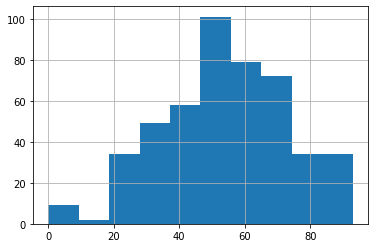

In [10]:
rawData.AGE_AT_VISIT_YRS.hist()

In [11]:
rawData.GENDER.value_counts()
rawData['female'] = rawData.GENDER=="F"
rawData.female = rawData.female.astype('int')

In [12]:
rawData['highFi02'] = rawData.TRIAGE_FIO2 > 50
rawData['highFi02'] = rawData['highFi02'].astype('int')

In [13]:
rawData = rawData[['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'TRIAGE_HR', 'TRIAGE_RR',
                   'TRIAGE_TEMP', 'highFi02', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 'ED_LAB_FERRITIN', 
                   'ED_LAB_CBC_PLT', 'ED_LAB_CBC_LYM', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 
                   'ED_LAB_HSTROP0', 'ED_LAB_IL6', 'covid', 'icu', 'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 
                   'ED_LAB_LDH', 'ED_LAB_CMP_ALB', 'MRN', 'PAT_ENC_CSN_ID']] 

In [14]:
caseAbstractions = caseAbstractions.rename(columns={'mrn' : 'MRN', 'pat_enc_csn_id' : 'PAT_ENC_CSN_ID' })
caseAbstractions = caseAbstractions.drop(labels=['intubation', 'shock', 'death', 'intubation_date', 'shock_date', 'death_date'], axis='columns')
rawData = rawData.merge(caseAbstractions, on=['MRN', 'PAT_ENC_CSN_ID'])
rawData = rawData.drop(labels=['MRN', 'PAT_ENC_CSN_ID'], axis='columns')
rawData.to_stata('rawData.dta')

In [15]:
rawData['totalMissing'] = rawData.isnull().sum(axis=1)
for col in rawData.columns:
    if ("TRIAGE" in col) or ("ED" in col):
        rawData[str(col)+"Missing"] = rawData[col].isnull()

In [16]:
for col in rawData.columns:
    if "Missing" in col:
        print(f"column: {col}, total missing: {rawData[col].sum()}, % missing: {rawData[col].sum()/len(rawData)}")

column: totalMissing, total missing: 1560, % missing: 5.1827242524916945
column: TRIAGE_SBPMissing, total missing: 1, % missing: 0.0033222591362126247
column: TRIAGE_DBPMissing, total missing: 1, % missing: 0.0033222591362126247
column: TRIAGE_HRMissing, total missing: 0, % missing: 0.0
column: TRIAGE_RRMissing, total missing: 0, % missing: 0.0
column: TRIAGE_TEMPMissing, total missing: 0, % missing: 0.0
column: ED_LAB_CRPMissing, total missing: 109, % missing: 0.36212624584717606
column: ED_LAB_DDIMERMissing, total missing: 115, % missing: 0.38205980066445183
column: ED_LAB_FERRITINMissing, total missing: 109, % missing: 0.36212624584717606
column: ED_LAB_CBC_PLTMissing, total missing: 33, % missing: 0.10963455149501661
column: ED_LAB_CBC_LYMMissing, total missing: 35, % missing: 0.11627906976744186
column: ED_LAB_CMP_CRMissing, total missing: 34, % missing: 0.11295681063122924
column: ED_LAB_CMP_TBILIMissing, total missing: 77, % missing: 0.2558139534883721
column: ED_LAB_HSTROP0Miss

### Imputation

In [17]:
# impute missing lab and vitals values

shortData = rawData[['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 
            'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 
            'ED_LAB_IL6', 'ED_LAB_CBC_LYM', 'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 'ED_LAB_LDH', 'ED_LAB_CMP_ALB',
            'TRIAGE_HR', 'TRIAGE_RR',  'TRIAGE_TEMP', 'icu', 'hypertension', 'diabetes', 'asthma', 'copd', 
            'chronic_lung', 'home_o2', 'osa', 'immunocompromised', 'pregnant', 'primaryOutcome', 'highFi02']]

import statsmodels.imputation.mice as mice

def ols_formula(df, dependent_var):
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    fml = ''
    for col in df_columns:
        fml = fml + ' + ' + col
    return fml

imputedData = mice.MICEData(shortData)

for var in ['AGE_AT_VISIT_YRS', 'female', 'TRIAGE_SBP', 'TRIAGE_DBP', 'ED_LAB_CRP', 'ED_LAB_DDIMER', 
            'ED_LAB_FERRITIN', 'ED_LAB_CBC_PLT', 'ED_LAB_CMP_CR', 'ED_LAB_CMP_TBILI', 'ED_LAB_HSTROP0', 
            'ED_LAB_IL6', 'ED_LAB_CBC_LYM', 'ED_LAB_CBC_HGB', 'ED_LAB_VBG_LAC', 'ED_LAB_LDH', 'ED_LAB_CMP_ALB',
            'TRIAGE_HR', 'TRIAGE_RR',  'TRIAGE_TEMP']:
    imputedData.set_imputer(var, formula=ols_formula(shortData, var))

imputedData.update_all(20)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:979: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


In [18]:
cleanedData = imputedData.data

In [19]:
withMissing = {}
for key in imputedData.models.keys():
    withMissing[key] = imputedData.models[key].fit().rsquared
withMissing

{'TRIAGE_DBP': 0.5413008314272544,
 'TRIAGE_SBP': 0.5036939321941363,
 'ED_LAB_CBC_HGB': 0.5268613682295612,
 'ED_LAB_CBC_PLT': 0.3212018713270214,
 'ED_LAB_CMP_CR': 0.23907273314695499,
 'ED_LAB_CBC_LYM': 0.31874879346133744,
 'ED_LAB_CMP_ALB': 0.3444597508635734,
 'ED_LAB_CMP_TBILI': 0.1876170922656616,
 'ED_LAB_FERRITIN': 0.2988225534861354,
 'ED_LAB_CRP': 0.44760902654468193,
 'ED_LAB_DDIMER': 0.3248313019015816,
 'ED_LAB_VBG_LAC': 0.5064453693923874,
 'ED_LAB_LDH': 0.5108583685018706,
 'ED_LAB_HSTROP0': 0.5360914473961815,
 'ED_LAB_IL6': 0.4256789730290058}

### Post imputation data management

In [20]:
cleanedData.rename(columns={'AGE_AT_VISIT_YRS' : 'age', 'TRIAGE_SBP' : 'sbp', 'TRIAGE_DBP' : 'dbp',
                            'TRIAGE_HR' : 'hr', 'TRIAGE_TEMP' : 'temp', 'ED_LAB_CRP' : 'crp', 
                            'ED_LAB_DDIMER' : 'dDimer', 'ED_LAB_FERRITIN' : 'ferritin',
                            'ED_LAB_CBC_PLT' : 'platelets', 'ED_LAB_CMP_CR' : 'creatinine',  
                            'ED_LAB_CMP_TBILI' : 'tbili', 'ED_LAB_HSTROP0' : 'hsTrop', 
                            'ED_LAB_IL6' : 'il6', 'ED_LAB_CBC_LYM' : 'lymph',
                            'ED_LAB_CBC_HGB': 'hgb', 'ED_LAB_VBG_LAC':'lac', 'ED_LAB_LDH':'ldh',
                            'ED_LAB_CMP_ALB': 'albumin', 'TRIAGE_HR':'hr',
                           'TRIAGE_RR':'rr', 'TRIAGE_TEMP':'temp'}, inplace=True)

In [21]:
# crude sofa score on imputed dataset
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence

# pao2/fi02
cleanedData['sofa'] = 0 # for the PaO2/fio2 ratio — looks like almost all our peopel are on room air, and we don't have pa02 on many 
cleanedData.loc[cleanedData.highFi02, 'sofa'] = 2 # crudely give elevated points for high Fi01, 

# platelets
sofaPlateletPoints = {0 : 4, 1 : 3, 2: 2, 3: 1, 4: 0}
cleanedData['plateletCat'] = pd.cut(cleanedData.platelets, [0, 20, 49, 99, 149, 10000]).values.codes
cleanedData['plateletPoints'] = [sofaPlateletPoints[cat] for cat in cleanedData.plateletCat]
cleanedData['sofa'] = cleanedData.sofa + cleanedData.plateletPoints

#gcs - missing...will just impute 0.2 points for eerybody...most are going to be very low
cleanedData['sofa'] = cleanedData.sofa + 0.2 

# t bili
cleanedData['biliCat'] = pd.cut(cleanedData.tbili, [0, 1.2, 1.99, 5.99, 11.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.biliCat

# blood pressure — no pressor data for now...
cleanedData['map'] = cleanedData.sbp * 1/3 + cleanedData.dbp * 2/3
cleanedData.loc[cleanedData.map < 70, 'sofa'] = cleanedData.sofa + 1

# creatinine
cleanedData['creatCat'] = pd.cut(cleanedData.creatinine, [0, 1.19, 1.99, 3.49, 4.99, 100]).values.codes
cleanedData['sofa'] = cleanedData.sofa + cleanedData.creatCat


### Defining models

In [22]:
factorsWithPriors = ['age', 'female', 'sofa', 'lymph']
factorsWithoutPriors =  ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp', 'hypertension', 'diabetes',
       'asthma', 'copd', 'chronic_lung', 'home_o2', 'osa', 'immunocompromised']
missCols = [col for col in cleanedData.columns if "Missing" in col]
outcomes = ['icu', 'primaryOutcome']

allCols = factorsWithPriors.copy()
allCols.extend(factorsWithoutPriors)
allCols.extend(missCols)
allPredictors = allCols.copy()
allCols.extend(outcomes)


modelData = cleanedData[allCols]

In [23]:
modelData.head()

,age,female,sofa,lymph,crp,dDimer,ferritin,hsTrop,hgb,lac,...,hypertension,diabetes,asthma,copd,chronic_lung,home_o2,osa,immunocompromised,icu,primaryOutcome
0,55.056,1,2.2,35.7,8.7,4.15,532.9,9.0,14.8,2.9,...,False,False,False,False,False,False,False,False,False,False
1,60.195,0,4.2,12.2,17.3,1.48,3898.2,10.0,14.9,2.0,...,False,False,False,False,False,False,False,False,False,False
2,32.023,1,0.2,17.6,4.7,0.38,261.6,3.0,13.3,1.2,...,False,False,False,False,False,False,False,False,False,False
3,55.636,1,0.2,17.5,8.0,1.48,1687.3,16.0,10.9,0.9,...,False,False,False,False,False,False,False,False,False,False
4,39.742,0,0.2,31.9,6.7,1.70,1474.6,6.0,14.5,0.8,...,False,False,False,False,False,False,False,False,False,False


In [24]:
modelData.icu.value_counts()

False    260
True      41
Name: icu, dtype: int64

In [25]:
modelData.primaryOutcome.value_counts()

False    247
True      54
Name: primaryOutcome, dtype: int64

In [26]:
# crude priors from:  Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study. The Lancet, 1–9. http://doi.org/10.1016/S0140-6736(20)30566-3
import pymc3 as pm

# mean center all the variables...
#for var in ['crp', 'dDimer', 'ferritin', 'hsTrop', 'sofa','lymph', 'hbg', 'lac', 'ldh', 'albumin']:
#     modelData[var] = modelData[var] - modelData[var].mean()


In [27]:
def getBetaNameForLab(lab):
    return 'beta' + lab.capitalize()

In [28]:
# primary outcome model
with pm.Model() as logitPrimaryOutcome:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for factor in factorsWithoutPriors:
        name = getBetaNameForLab(factor)
        setattr(logitPrimaryOutcome, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(logitPrimaryOutcome, factor, pm.Data(factor, modelData[factor]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
        betaFemale * modelData.female 
    
    for factor  in factorsWithoutPriors:   
        mu += getattr(logitPrimaryOutcome, getBetaNameForLab(factor)) * getattr(logitPrimaryOutcome, factor)
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.primaryOutcome)

    tracePrimaryOutcome = pm.sample(1000, tune=3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaImmunocompromised, betaOsa, betaHome_o2, betaChronic_lung, betaCopd, betaAsthma, betaDiabetes, betaHypertension, betaTemp, betaRr, betaHr, betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, alpha]
Sampling 4 chains, 1 divergences: 100%|██████████| 16000/16000 [02:12<00:00, 120.43draws/s]
The acceptance probability does not match the target. It is 0.8822781054513754, but should be close to 0.8. Try to increase the number of tuning steps.


In [29]:
# main ICU model
with pm.Model() as logitICUWIthPriors:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
    betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
    betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
    betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


    # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
    for factor in factorsWithoutPriors:
        name = getBetaNameForLab(factor)
        setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
        setattr(logitICUWIthPriors, factor, pm.Data(factor, modelData[factor]))
        
    
    # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
    mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
        betaFemale * modelData.female 
    
    for factor in factorsWithoutPriors:
        mu += getattr(logitICUWIthPriors, getBetaNameForLab(factor)) * getattr(logitICUWIthPriors, factor)
        
    θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
    y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

    trace_ICU = pm.sample(1000, tune=3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaImmunocompromised, betaOsa, betaHome_o2, betaChronic_lung, betaCopd, betaAsthma, betaDiabetes, betaHypertension, betaTemp, betaRr, betaHr, betaAlbumin, betaLdh, betaLac, betaHgb, betaHstrop, betaFerritin, betaDdimer, betaCrp, betaFemale, betaLymph, betaSofa, betaAge, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [02:05<00:00, 127.34draws/s]


In [30]:
# # icu model that includes missing variable flags
# def getBetaNameForLab(lab):
#     return 'beta' + lab.capitalize()

# labs = ['crp', 'dDimer', 'ferritin', 'hsTrop', 'hgb', 'lac', 'ldh', 'albumin', 'hr', 'rr', 'temp']
# missCols = [col for col in modelData.columns if "Missing" in col]

# with pm.Model() as logitICUWIthPriors:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
#     betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
#     betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
#     betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
#     betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)
#     #betaTotalMissing = pm.Normal('betaTotalMissing', mu=0, sd=10)
#     #totalMissing = pm.Data('totalMissing', modelData.totalMissing)

#     # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
#     for lab in labsVitals:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
#     # explore individual missing variables
#     for lab in missCols:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, modelData[lab]))
        
        
#     # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
#     mu = alpha + betaAge * modelData.age + betaSofa * modelData.sofa + betaLymph * modelData.lymph + \
#         betaFemale * modelData.female 
    
#     for lab  in labsVitals:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
#     for lab  in missCols:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)


#     θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
#     y_1 = pm.Bernoulli('y_1', p=θ, observed=modelData.icu)

#     trace_ICU_Missing = pm.sample(1000, tune=3000, cores=4)

In [31]:
# # icu model on the dataset with minimal missingess
# def getBetaNameForLab(lab):
#     return 'beta' + lab.capitalize()

# with pm.Model() as logitICUWIthPriors:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
#     betaAge = pm.Normal('betaAge', mu=0.095, sd=0.05)
#     betaSofa = pm.Normal('betaSofa', mu=1.73, sd=0.5)
#     betaLymph = pm.Normal('betaLymph', mu=-1.66, sd=0.9)
#     betaFemale = pm.Normal('betaFemale', mu=-0.49, sd=0.3)


#     # dynamically setting the lab data and prior sothat we can do programatic ppcs on them
#     for lab in labsVitals:
#         name = getBetaNameForLab(lab)
#         setattr(logitICUWIthPriors, name, pm.Normal(name, mu=0, sd=0.05))
#         setattr(logitICUWIthPriors, lab, pm.Data(lab, noMissing[lab]))
        
    
#     # mu is the sum of hte cmponents with specified priors + those with pessimistic pirors that we defined
#     mu = alpha + betaAge * noMissing.age + betaSofa * noMissing.sofa + betaLymph * noMissing.lymph + \
#         betaFemale * noMissing.female 
    
#     for lab  in labsVitals:   
#         mu += getattr(logitICUWIthPriors, getBetaNameForLab(lab)) * getattr(logitICUWIthPriors, lab)
        
#     θ = pm.Deterministic('θ', pm.math.sigmoid(mu))
    
#     y_1 = pm.Bernoulli('y_1', p=θ, observed=noMissing.icu)

#     trace_ICU_NoMissing = pm.sample(1000, tune=3000, cores=4)

### Reporting

In [32]:
def assessOverallPerformance(model, trace, name):
    ppcs = pm.sample_ppc(trace, model=model, samples=1000)
    posteriorName = 'posterior' + name

    modelData[posteriorName] = ppcs['y_1'].mean(axis=0)

    preds = np.rint(modelData[posteriorName]).astype('int')
    print(f'Accuracy: {accuracy_score(modelData.icu, preds):.3f}')
    print(f'f1 score: {f1_score(modelData.icu, preds):.3f}')
    roc = roc_auc_score(modelData.icu, modelData[posteriorName])
    print(f'ROC: {roc:.3f}')
    return ppcs, roc

In [33]:
def assessParameterInfluence(model, trace):   
    labsToKeep = []
    marginalOutputsForLab = {}
    marginalInputsForLab = {}
    ninetyMinusTenForLab = {}

    labs=['totalMissing']


    for var in factorsWithoutPriors:
        with model:
            valuesToCheck = {'min': modelData[var].min(), '1st':modelData[var].quantile(0.01),
                             '10th':modelData[var].quantile(0.10), '25th':modelData[var].quantile(0.25), 
                             '50th':modelData[var].quantile(0.50), '75th':modelData[var].quantile(0.75), 
                             '90th':modelData[var].quantile(0.90), '99th':modelData[var].quantile(0.99),
                             'max':modelData[var].max()}
            ppcsAtValue = dict.fromkeys(valuesToCheck.keys())

            for key, value in valuesToCheck.items():
                pm.model.set_data({var: np.repeat(value, len(modelData))})
                pccsForLabValue = pm.sample_posterior_predictive(trace, samples=1000, progressbar=False)
                ppcsAtValue[key] = pccsForLabValue['y_1'].mean(axis=0).mean()
                marginalOutputsForLab[var] = ppcsAtValue
                marginalInputsForLab[var] = valuesToCheck
            ninetyMinusTen = ppcsAtValue['90th'] - ppcsAtValue['10th']
            ninetyMinusTenForLab[var] = ninetyMinusTen

            if np.abs(ninetyMinusTen) > 0.05:
                labsToKeep.append(var)
    return (labsToKeep, marginalOutputsForLab, marginalInputsForLab, ninetyMinusTenForLab)

In [34]:
def getDataObject(model, trace, ppc):
    with model:

        data = az.from_pymc3(
            trace=trace,
            prior=pm.sample_prior_predictive(),
            posterior_predictive=ppc,
            model=model
        )
    return data


### Assess primary outcome

In [35]:
primaryPPCs, primaryROC = assessOverallPerformance(logitPrimaryOutcome, tracePrimaryOutcome, "PrimaryOutcome")
primaryToKeep, primaryMarignalOutputs, primaryMarginalInputs, primaryNinetyMinusTen = assessParameterInfluence(logitPrimaryOutcome, tracePrimaryOutcome)
primaryData = getDataObject(logitPrimaryOutcome, tracePrimaryOutcome, primaryPPCs )

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 509.28it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarnin

Accuracy: 0.877
f1 score: 0.519
ROC: 0.835


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sam

In [36]:
az.summary(tracePrimaryOutcome).head(24)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-7.178,4.547,-15.605,1.492,0.083,0.062,2989.0,2659.0,2997.0,2400.0,1.0
betaAge,0.041,0.013,0.015,0.066,0.000,0.000,3980.0,3791.0,3996.0,2828.0,1.0
betaSofa,0.092,0.151,-0.195,0.378,0.002,0.002,4414.0,2105.0,4415.0,2757.0,1.0
betaLymph,-0.051,0.025,-0.098,-0.002,0.000,0.000,4899.0,3909.0,4940.0,2515.0,1.0
betaFemale,-0.521,0.241,-0.965,-0.063,0.004,0.003,4369.0,3760.0,4368.0,2704.0,1.0
betaCrp,0.042,0.022,-0.000,0.082,0.000,0.000,4835.0,3768.0,4846.0,3213.0,1.0
betaDdimer,0.020,0.032,-0.039,0.078,0.000,0.000,4845.0,2543.0,4861.0,3183.0,1.0
betaFerritin,0.000,0.000,-0.000,0.000,0.000,0.000,3865.0,2512.0,3955.0,3049.0,1.0
betaHstrop,0.011,0.007,-0.002,0.026,0.000,0.000,4097.0,3208.0,4160.0,2066.0,1.0
betaHgb,0.001,0.045,-0.084,0.089,0.001,0.001,4630.0,1764.0,4632.0,2605.0,1.0


In [37]:
primaryNinetyMinusTen

{'crp': 0.0829833887043189,
 'dDimer': 0.00966445182724257,
 'ferritin': 0.04252159468438532,
 'hsTrop': 0.04887375415282391,
 'hgb': -0.0007641196013287166,
 'lac': 0.0019534883720929708,
 'ldh': 0.07689036544850492,
 'albumin': -0.00012292358803978054,
 'hr': 0.016089700996677725,
 'rr': 0.009558139534883936,
 'temp': -0.00014285714285700024,
 'hypertension': 3.322259136206984e-05,
 'diabetes': 3.6544850498421155e-05,
 'asthma': -5.9800664451770125e-05,
 'copd': 6.644518272436173e-05,
 'chronic_lung': -3.3222591362180864e-05,
 'home_o2': -7.973421926921187e-05,
 'osa': -0.00019269102990027154,
 'immunocompromised': 9.966777408620953e-05}

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_dist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c33e350d0>,
      dtype=object)

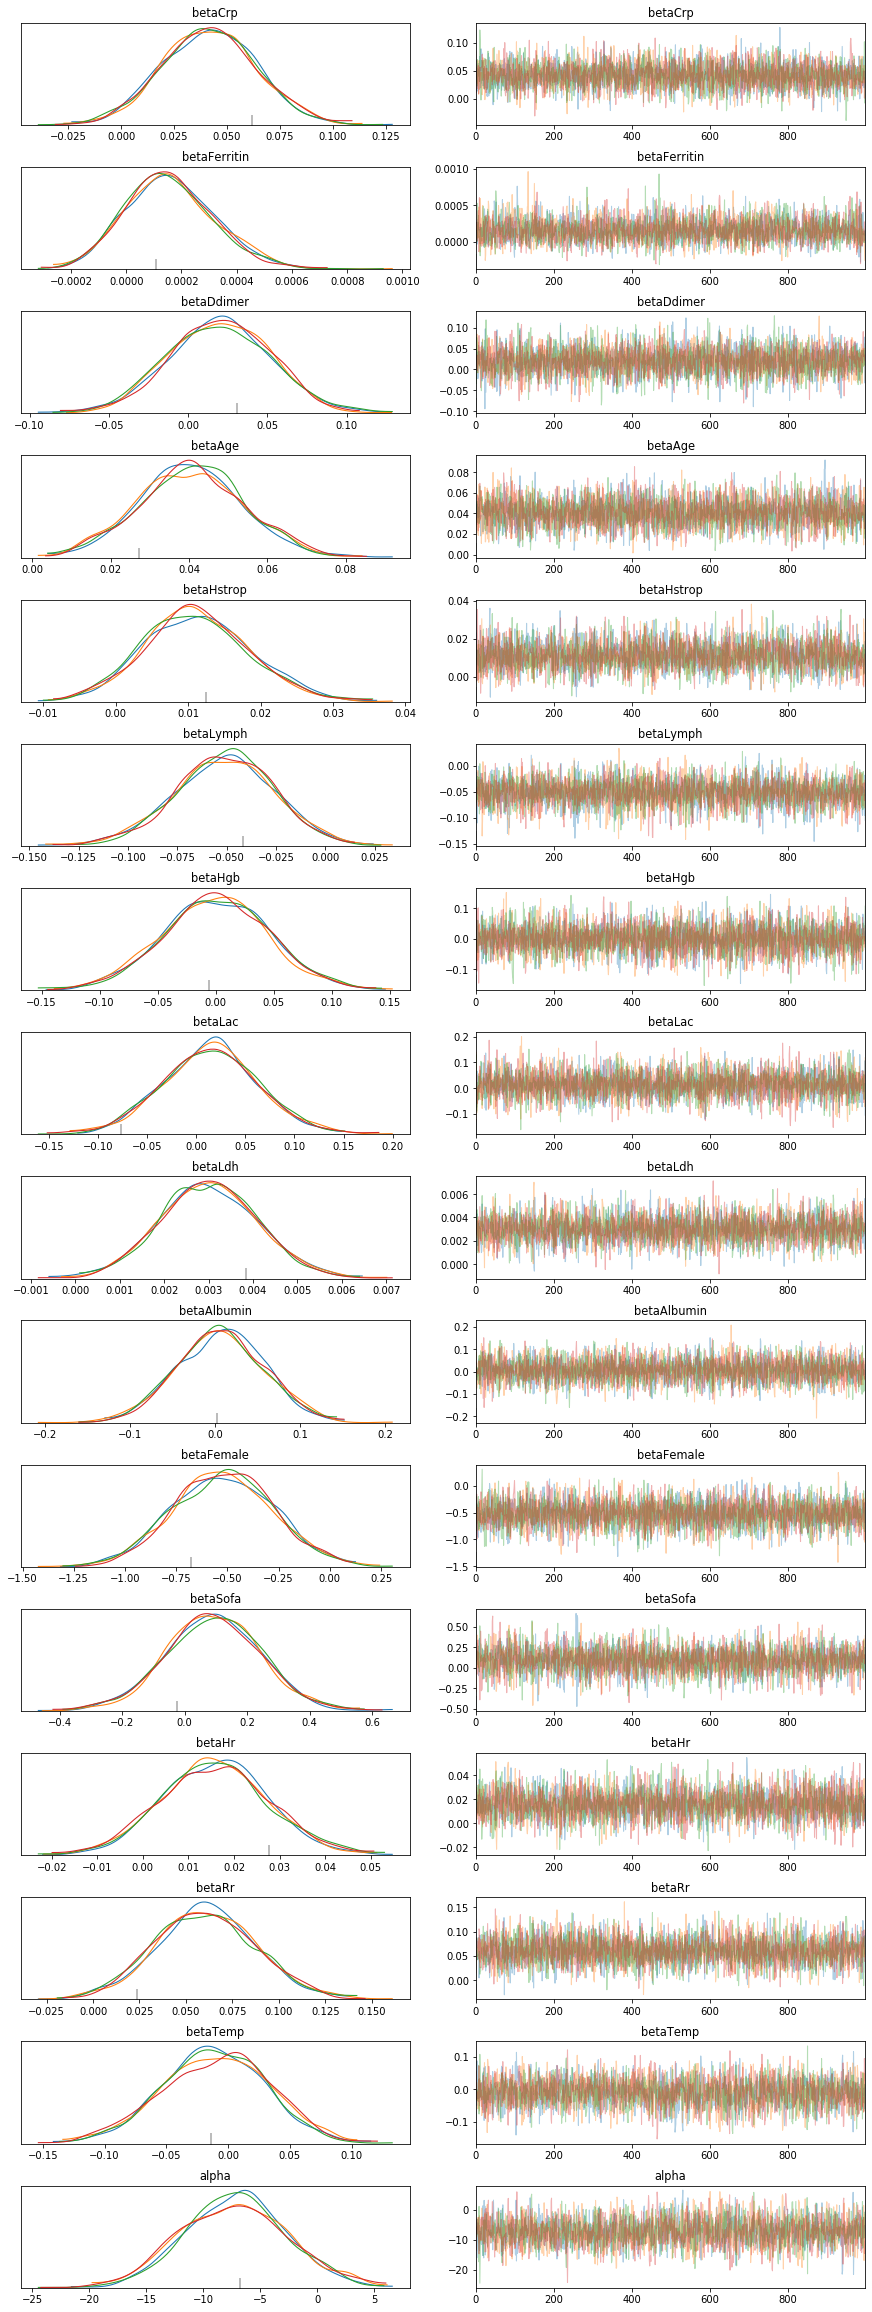

In [38]:
az.plot_trace(tracePrimaryOutcome, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                    'betaFemale', 'betaSofa', 'betaHr', 'betaRr', 'betaTemp', 'alpha'])

### ICU Model

In [39]:
icuPPCs, icuROC = assessOverallPerformance(logitICUWIthPriors, trace_ICU, "ICU")
icuToKeep, icuMarignalOutputs, icuMarginalInputs, icuNinetyMinusTen = assessParameterInfluence(logitICUWIthPriors, trace_ICU)
icuData = getDataObject(logitICUWIthPriors, trace_ICU, icuPPCs )

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 513.84it/s]
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarnin

Accuracy: 0.904
f1 score: 0.525
ROC: 0.855


/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pymc3/sam

In [40]:
az.summary(trace_ICU).head(16)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-5.173,4.485,-13.448,3.315,0.093,0.066,2314.0,2277.0,2319.0,2469.0,1.0
betaAge,0.028,0.014,0.002,0.053,0.000,0.000,2664.0,2397.0,2674.0,2675.0,1.0
betaSofa,0.179,0.173,-0.144,0.506,0.003,0.002,3626.0,3217.0,3630.0,2747.0,1.0
betaLymph,-0.035,0.025,-0.082,0.014,0.000,0.000,3684.0,2949.0,3721.0,2923.0,1.0
betaFemale,-0.372,0.251,-0.848,0.089,0.004,0.003,3638.0,3161.0,3631.0,2786.0,1.0
betaCrp,0.030,0.024,-0.016,0.072,0.000,0.000,3989.0,3661.0,3972.0,3118.0,1.0
betaDdimer,0.028,0.032,-0.032,0.088,0.000,0.000,4216.0,3378.0,4227.0,3076.0,1.0
betaFerritin,-0.000,0.000,-0.000,0.000,0.000,0.000,2951.0,2031.0,3011.0,2579.0,1.0
betaHstrop,-0.007,0.010,-0.025,0.012,0.000,0.000,3258.0,2373.0,3348.0,2658.0,1.0
betaHgb,-0.015,0.046,-0.102,0.069,0.001,0.001,3928.0,2146.0,3913.0,2944.0,1.0


In [41]:
icuNinetyMinusTen

{'crp': 0.049890365448504975,
 'dDimer': 0.010481727574750799,
 'ferritin': -0.0003687707641196192,
 'hsTrop': -0.036727574750830605,
 'hgb': -0.005730897009966762,
 'lac': 0.001990033222591392,
 'ldh': 0.18717607973421932,
 'albumin': -0.001362126245847195,
 'hr': 0.009093023255813959,
 'rr': 0.06233554817275755,
 'temp': -0.00464784053156142,
 'hypertension': -0.00017275747508316286,
 'diabetes': 0.0004518272425250158,
 'asthma': 0.0005847176079734062,
 'copd': 0.000571428571428334,
 'chronic_lung': 0.00013621262458451966,
 'home_o2': -0.0007973421926910085,
 'osa': -0.00041860465116283496,
 'immunocompromised': -0.0002857142857141115}

### Calibration 

In [45]:
outputDF = pd.DataFrame({'predicted icu' : modelData.posteriorICU, 'icu' : modelData.icu,
                         'predicted primary outcome' : modelData.posteriorPrimaryOutcome,
                         'primary outcome' : modelData.primaryOutcome})
outputDF['icuDecile'] = pd.qcut(outputDF['predicted icu'], 10)
outputDF['primaryOutcomeDecile'] = pd.qcut(outputDF['predicted primary outcome'], 10)

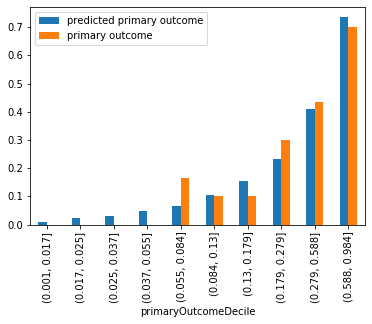

In [46]:
# primary outcome
from datetime import date
outputDF[['predicted primary outcome', 'primary outcome', 'primaryOutcomeDecile']].groupby('primaryOutcomeDecile').mean().plot.bar()
plt.savefig(f'static/primaryOutcomeCalibration{str(date.today())}.jpg')


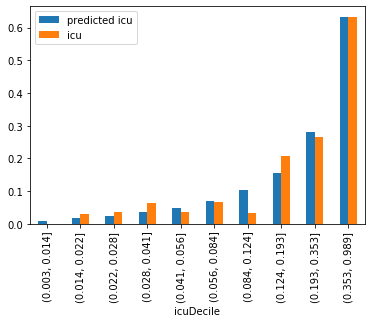

In [47]:
# icu
outputDF[['predicted icu', 'icu', 'icuDecile']].groupby('icuDecile').mean().plot.bar()
plt.savefig(f'static/icuCalibration{str(date.today())}.jpg')

In [51]:
def saveModelOutcomes(trace, ninetyMinusTen, name):
    modelCoefficients = az.summary(trace, var_names=['betaCrp', 'betaFerritin', 'betaDdimer', 'betaAge', 'betaHstrop',
                                      'betaLymph', 'betaHgb', 'betaLac', 'betaLdh', 'betaAlbumin',
                                      'betaFemale', 'betaSofa',  'betaHr', 'betaRr', 'betaTemp', 'alpha'])[['mean', 'sd']]
    modelCoefficients.rename(columns={'mean': 'beta', 'sd':'sdBeta'}, inplace=True)
    for key, value in ninetyMinusTen.items():
        modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'priority'] = np.abs(value)
        modelCoefficients.loc[(modelCoefficients.index == getBetaNameForLab(key)),'p50'] = modelData[key].quantile(0.50)
    
    for i, row in modelCoefficients.iterrows():
        if row.name[0:4] == 'beta':
            modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name[4:].lower()
        else:
            modelCoefficients.loc[modelCoefficients.index==row.name, 'name'] = row.name
    modelCoefficients.to_stata(f'{name}Coeffs-{str(date.today())}.dta')
    return modelCoefficients


In [52]:
icuCoeffs = saveModelOutcomes(trace_ICU, icuNinetyMinusTen, "ICU")
primaryCoeffs = saveModelOutcomes(tracePrimaryOutcome, primaryNinetyMinusTen, "PrimaryOutcome")
modelData.to_stata(f'modelData-{str(date.today())}.dta')

In [50]:
import json


modelPerformance = {}
modelPerformance['icuROC'] = icuROC
modelPerformance['primaryROC'] = primaryROC

with open(f'modelPerformance-{str(date.today())}.json', 'w') as outfile:
    json.dump(modelPerformance, outfile)

In [79]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(y=modelData["posteriorICU"], name="ICU Risk Distribution"), )
fig.add_trace(go.Box(y=modelData["posteriorPrimaryOutcome"], name="Primary Outcome Risk Distribution"), )

fig.add_trace(go.Scatter(y=[0.5]))
fig.show()

In [113]:
import plotly.figure_factory as ff


prob = 0.2
kde = scipy.stats.gaussian_kde(modelData["posteriorPrimaryOutcome"]).pdf(prob)

# Create distplot with custom bin_size
fig = ff.create_distplot([modelData["posteriorPrimaryOutcome"]], ['Primary Outcome'], bin_size=.05, show_rug=False)
fig.add_trace(go.Scatter(y=kde, x=[prob], marker={'size':40, 'color':'red'}, name="Entered Risk Parameters"))
fig.show()

In [117]:
fig.data[2]['x']=[0.4]

In [94]:
import scipy.stats

test = scipy.stats.gaussian_kde(modelData["posteriorPrimaryOutcome"])

In [101]:
test.pdf(0.05)

array([3.2767597])

In [35]:
# workflow...

# download data
# clean datat (in this worksheet)
# impute missing values
# run baseline model
# prioritize coefficients
# export coefficients, data file and model performance
# update the priority in teh UI — done
# 

In [36]:
# there is a fairly reasonable agreement between our baseline bayesian model and a default-tuned elastic net
# that seesm liek a decent argument that our pessimism was calibrated reasonably...

In [37]:
# from glmnet import LogitNet

# m = LogitNet()
# m = m.fit(modelData.loc[:,!modelData.columns.in(['icu', 'posteriorProbabilities']), modelData.icu)

SyntaxError: invalid syntax (<ipython-input-37-3e104641e805>, line 4)

In [ ]:
#modelData

In [ ]:
#m.coef_